<h1>Brands Recognition</h1>
<a href="https://pdfs.semanticscholar.org/280e/57ea3e882f82a60065fedde058ce00769c06.pdf">Toward Retail Product Recognition on Grocery Shelves</a> proposes approach to recognize following 10 brands. It is simplified task because there are much more brands in the dataset, but they are thrown away.

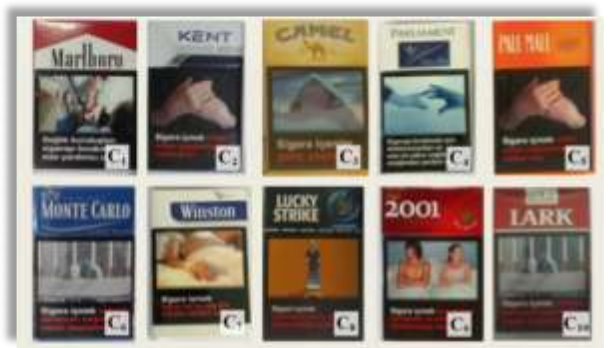

In [1]:
from IPython.display import Image
Image('docs/images/brands.png', width=300)

They proposed approach to brands recognition as a combination of following algorithms.

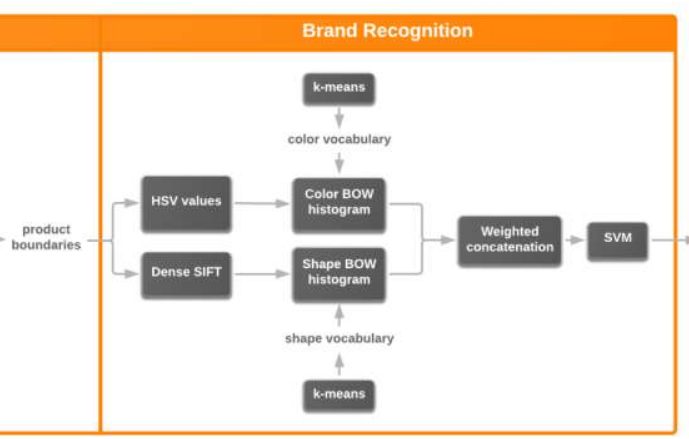

In [2]:
Image('docs/images/brand_recognition.png', width=600)

This approach accuracy is:

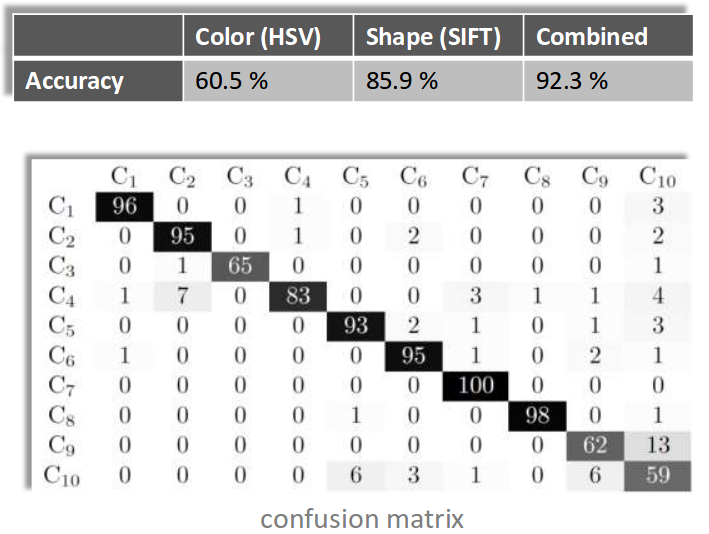

In [3]:
Image('docs/images/brand_recognition_accuracy.png', width=600)

Let's show that CNN gives better performace much easier way. We will use this <a href="https://github.com/keras-team/keras/blob/master/examples/cifar10_resnet.py">keras example</a> as baseline.

In [4]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import pandas as pd
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras import backend as K


%matplotlib inline

/home/andrey/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
# path to data and shelves images
data_path = 'data/'
shelf_images = 'data/images/ShelfImages/'

In [6]:
# load data from previous step
photos_df = pd.read_pickle(f'{data_path}photos.pkl')
products_df =  pd.read_pickle(f'{data_path}products.pkl')

In [7]:
# neural networks work with input of fixed size, so we need to resize our
# packs images to the chosen size. The size is some kind of metaparameter and 
# you should try different variants. Logically, the bigger size you select,
# the better performace you'll have. Unfortunatelly it is not true, because 
# of over fitting. The more parameters your neural network have, the easier it
# became over fitted
num_classes = 10
SHAPE_WIDTH = 80
SHAPE_HEIGHT = 120

In [8]:
# resize pack to fixed size SHAPE_WIDTH x SHAPE_HEIGHT
def resize_pack(pack):
    fx_ratio = SHAPE_WIDTH / pack.shape[1]
    fy_ratio = SHAPE_HEIGHT / pack.shape[0]    
    pack = cv2.resize(pack, (0, 0), fx=fx_ratio, fy=fy_ratio)
    return pack[0:SHAPE_HEIGHT, 0:SHAPE_WIDTH]

In [9]:
# x - image, y - class, f - is_train flag
x, y, f = [], [], []
for file, is_train in photos_df[['file', 'is_train']].values:
    photo_rects = products_df[products_df.file == file]
    rects_data = photo_rects[['category', 'xmin', 'ymin', 'xmax', 'ymax']]
    im = cv2.imread(f'{shelf_images}{file}')
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    for category, xmin, ymin, xmax, ymax in rects_data.values:
        if category == 0:
            continue
        pack = resize_pack(np.array(im[ymin:ymax, xmin:xmax]))
        x.append(pack)
        f.append(is_train)
        y.append(category - 1)

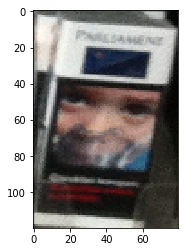

In [10]:
# display one SHAPE_WIDTH x SHAPE_HEIGHT resized pack image, 
# it is hard to recognize category with our eyes, let's see
# how neural network will do the job
plt.imshow(x[60])

In [11]:
# let's split the data to train/validation sets based on our is_train flag
x = np.array(x)
y = np.array(y)
f = np.array(f)
x_train, x_validation, y_train, y_validation = x[f], x[~f], y[f], y[~f]
# save validation images
x_validation_images = x_validation

In [12]:
# convert y_train and y_validation to one-hot arrays
y_train = keras.utils.to_categorical(y_train, num_classes)
y_validation = keras.utils.to_categorical(y_validation, num_classes)

In [13]:
# normalize x_train, x_validation
x_train = x_train.astype('float32')
x_validation = x_validation.astype('float32')
x_train /= 255
x_validation /= 255

In [14]:
# let's see what do we have
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_validation.shape[0], 'validation samples')

x_train shape: (1969, 120, 80, 3)
y_train shape: (1969, 10)
1969 train samples
775 validation samples


In [15]:
# let's build our ResNet CNN. We don't do any significant changes to keras example
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 5:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=x_train.shape[1:])
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

n = 3
version = 1
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2
model_type = 'ResNet%dv%d' % (depth, version)

model = resnet_v1(input_shape=x_train.shape[1:], depth=depth, num_classes=num_classes)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)), metrics=['accuracy'])

Learning rate:  0.001


In [16]:
# let's see our model architecture and how may trainable params does it have
# model.summary()

In [17]:
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

In [18]:
# let's run training process, 20 epochs is enough
batch_size = 50
epochs = 15
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_validation, y_validation),
                    epochs=epochs, verbose=1, workers=4, 
                    callbacks=[LearningRateScheduler(lr_schedule)])


Epoch 1/15
Learning rate:  0.001
40/40 [==============================] - 21s 532ms/step - loss: 1.0094 - acc: 0.7480 - val_loss: 2.4216 - val_acc: 0.3987
Epoch 2/15
Learning rate:  0.001
40/40 [==============================] - 16s 395ms/step - loss: 0.2855 - acc: 0.9600 - val_loss: 0.5790 - val_acc: 0.8542
Epoch 3/15
Learning rate:  0.001
40/40 [==============================] - 16s 397ms/step - loss: 0.1917 - acc: 0.9857 - val_loss: 0.7198 - val_acc: 0.8000
Epoch 4/15
Learning rate:  0.001
40/40 [==============================] - 16s 397ms/step - loss: 0.1808 - acc: 0.9847 - val_loss: 1.6440 - val_acc: 0.6297
Epoch 5/15
Learning rate:  0.001
40/40 [==============================] - 16s 398ms/step - loss: 0.1711 - acc: 0.9865 - val_loss: 0.3889 - val_acc: 0.9071
Epoch 6/15
Learning rate:  0.001
40/40 [==============================] - 16s 398ms/step - loss: 0.1588 - acc: 0.9880 - val_loss: 2.4500 - val_acc: 0.5458
Epoch 7/15
Learning rate:  0.0001
40/40 [=============================

In [19]:
# let's estimate our result
scores = model.evaluate(x_validation, y_validation, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

775/775 [==============================] - 2s 3ms/step
Test loss: 0.3332095519188912
Test accuracy: 0.9238709678188447


In [20]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [21]:
# let's draw confusion matrix to check classes recognition performance
y_validation_cls = np.argmax(y_validation, axis=1)
y_validation_predict = model.predict(x_validation)
y_validation_predict_cls = np.argmax(y_validation_predict, axis=1)

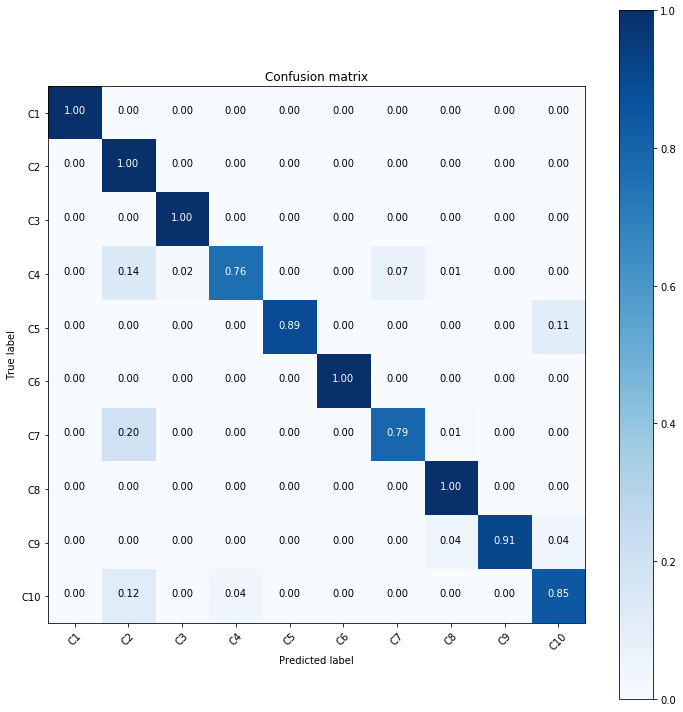

In [22]:
fig = plt.gcf()
fig.set_size_inches(10, 10)
cnf_matrix = confusion_matrix(y_validation_cls, y_validation_predict_cls)
plot_confusion_matrix(cnf_matrix, [f'C{i+1}' for i in range(num_classes)], 
                      title='Confusion matrix', normalize=True)

Sometimes it helps to see the most prominent representatives of confussion matrix.

In [23]:
power = np.array([y_validation_predict[i][y_validation_predict_cls[i]] 
                  for i in range(len(y_validation_predict_cls))])


margin = 5
width = num_classes * SHAPE_WIDTH + (num_classes - 1) * margin
height = num_classes * SHAPE_HEIGHT + (num_classes - 1) * margin
confusion_image = np.zeros((height, width, 3), dtype='i')
for i in range(num_classes):
    for j in range(num_classes):
        flags = [(y_validation_cls == i) & (y_validation_predict_cls == j)]
        if not np.any(flags):
            continue
        max_cell_power = np.max(power[flags])
        index = np.argmax(flags & (power == max_cell_power))
        ymin, xmin = (SHAPE_HEIGHT+margin) * i, (SHAPE_WIDTH+margin) * j
        ymax, xmax = ymin + SHAPE_HEIGHT, xmin + SHAPE_WIDTH
        confusion_image[ymin:ymax, xmin:xmax, :] = x_validation_images[index]
        

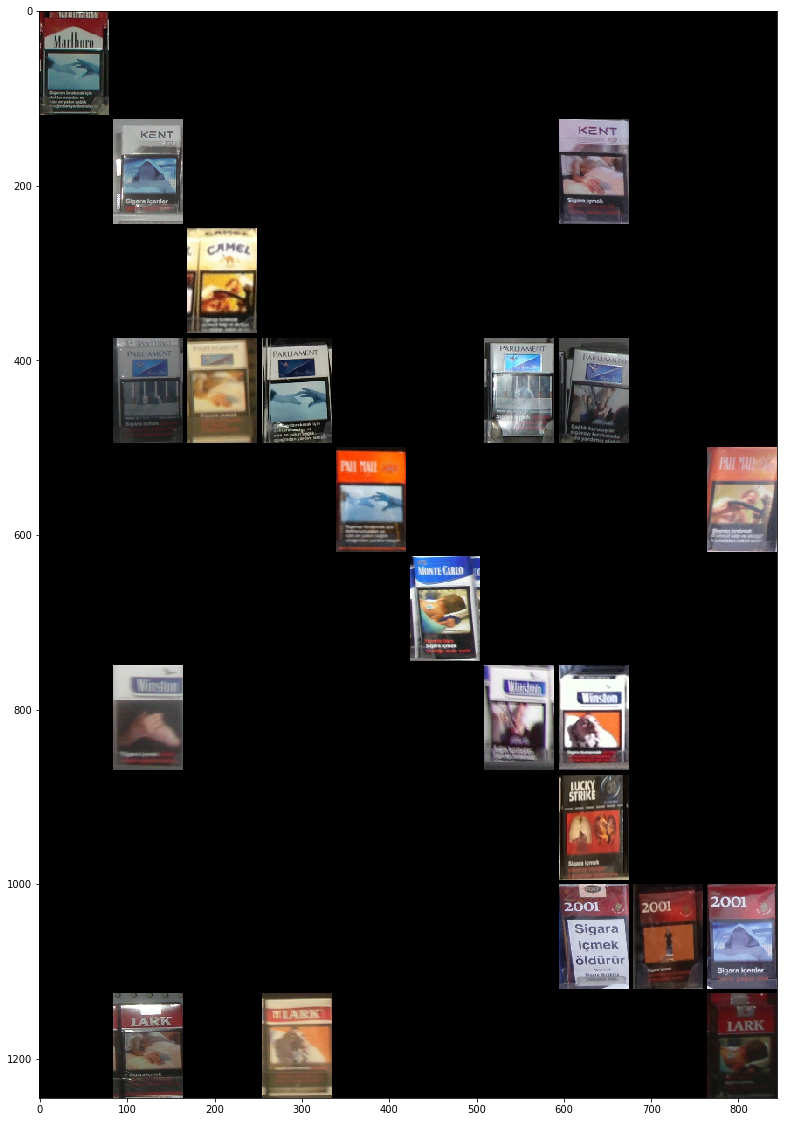

In [24]:
fig = plt.gcf()
fig.set_size_inches(20, 20)
plt.imshow(confusion_image)

<h3>How convolutional neural networks see the world</h3>
The following code doesn't have any significance for the task, but produces nice pictures.

In [25]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

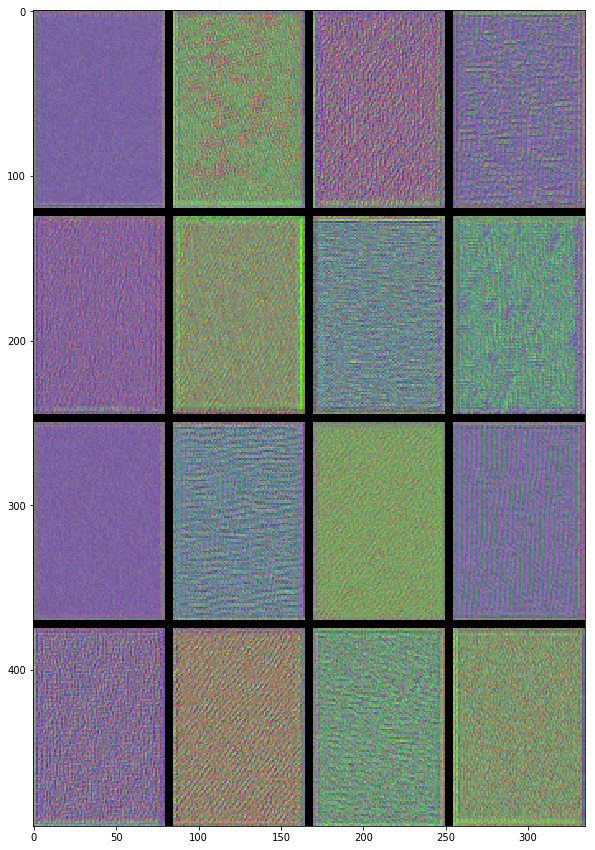

In [26]:
n = 4

margin = 5
width = n * SHAPE_WIDTH + (n - 1) * margin
height = n * SHAPE_HEIGHT + (n - 1) * margin
stitched_filters = np.zeros((height, width, 3), dtype='i')


input_img = model.input
# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])
layer_name = 'conv2d_5'
for i in range(n):
    for j in range(n):
        filter_index = i * n + j
        layer_output = layer_dict[layer_name].output
        loss = K.mean(layer_output[:, :, :, filter_index])
        grads = K.gradients(loss, input_img)[0]
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
        iterate = K.function([input_img], [loss, grads])
        input_img_data = np.random.random((1, SHAPE_HEIGHT, SHAPE_WIDTH, 3))
        input_img_data = input_img_data * 20 + 128.
        step = 1.
        for k in range(20):
            loss_value, grads_value = iterate([input_img_data])
            input_img_data += grads_value * step
        img = deprocess_image(input_img_data[0])
        ymin, xmin = (SHAPE_HEIGHT+margin) * i, (SHAPE_WIDTH+margin) * j
        ymax, xmax = ymin + SHAPE_HEIGHT, xmin + SHAPE_WIDTH
        stitched_filters[ymin:ymax, xmin:xmax, :] = img

fig = plt.gcf()
fig.set_size_inches(15, 15)
plt.imshow(stitched_filters)